# Model rozpoznający Fake news

# Wstępne ustawienia

In [1]:
!pip install torchsummaryX matplotlib tqdm wordcloud ipywidgets widgetsnbextension scikit-learn seaborn torchviz

## Import bibliotek

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import string
import requests

from datetime import datetime
from tqdm import tqdm
from torchsummaryX import summary
from torch.utils import tensorboard
from random import randrange
from collections import Counter, defaultdict
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from torchviz import make_dot

## Zdefiniowanie stałych

In [3]:
NIGHTLY = False
USE_MPS = False

LOGS_PATH = 'logi/FakeNews'
DATA_PATH = 'data/FakeNews'
GRAPH_PATH = 'graph/FakeNews'
PROJECTOR_PATH = 'projector/FakeNews'
MODEL_PATH = 'model/FakeNews'
DATA_FILENAME = 'WelFake.csv'

DATA_URL = 'https://zenodo.org/record/4561253/files/WELFake_Dataset.csv?download=1'

SEQ_LENGTH = 400

In [4]:
TRAIN_LEN_SPLIT = 0.7
VAL_LEN_SPLIT = 0.1
TEST_LEN_SPLIT = 0.2

tmpSum = (TRAIN_LEN_SPLIT + VAL_LEN_SPLIT + TEST_LEN_SPLIT)
assert(tmpSum <= 1.0)
assert(tmpSum > 0)

## Ustawienie rozszerzeń notebooka

In [5]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


## Wybór urządzenia do treningu

In [6]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available() and USE_MPS:
  DEVICE = torch.device('mps')
else:
  DEVICE = torch.device('cpu')

## Utworzenie potrzebnych katalogów

In [7]:
list_folders = [
  LOGS_PATH,
  DATA_PATH,
  PROJECTOR_PATH,
  GRAPH_PATH,
  MODEL_PATH
]

for x in list_folders:
  if not os.path.exists(x):
    os.makedirs(x)

# Zbiór danych
Pobrane z
https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

## Funkcja pobierająca CSV from URL_PATH save to DATA_PATH

In [8]:
def download_csv(url: string, file_path: string, filename: string):
  req = requests.get(url)
  body = req.content

  with open(os.path.join(file_path, filename), 'wb') as f:
    f.write(body)

## Pobranie pliku CSV i zapisanie go do pliku

In [9]:
if not os.path.exists(os.path.join(DATA_PATH, DATA_FILENAME)):
  download_csv(DATA_URL, DATA_PATH, DATA_FILENAME)

## Wczytanie pobranego pliku do pandas

In [10]:
data = pd.read_csv(os.path.join(os.path.join(DATA_PATH, DATA_FILENAME)))
# data = pd.read_csv(DATA_URL)

### Zmiana nazwy pól

In [11]:
data = data.rename(columns={'Unnamed: 0': 'ID'})
data['category'] = np.where(data['label'] == 0, 'real', 'fake')
data.head()

,ID,title,text,label,category
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,fake
1,1,NaN,Did they post their votes for Hillary already?,1,fake
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,fake
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,real
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,fake


### Usunięcie wierszy niezawierającej treści artykułu

In [12]:
data = data.replace(r'^\s*$', np.nan, regex=True)
data = data.dropna(subset=['text'])

### Podsumowanie liczby artykułów z podziałem na kategorie

0 - Fake<br>1 - Real

In [13]:
data.groupby(['category'])['ID'].count()

category
fake    36324
real    35027
Name: ID, dtype: int64

<Axes: title={'center': 'Podział artykułów na prawdziwe i fałszywe'}, ylabel='ID'>

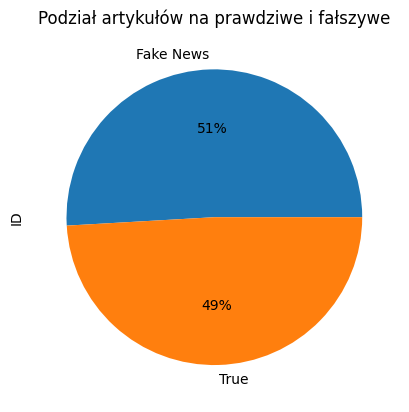

In [14]:
data.groupby(['category'])['ID'].count().plot(
  kind='pie', y='ID', autopct='%1.0f%%', labels=['Fake News', 'True'],
  title='Podział artykułów na prawdziwe i fałszywe'
)

### Rozkład ilości znaków we wszystkich artykułach

(array([     0,   5000,  10000,  15000,  20000,  25000,  30000,  35000,
         40000,  45000,  50000,  55000,  60000,  65000,  70000,  75000,
         80000,  85000,  90000,  95000, 100000, 105000, 110000, 115000,
        120000, 125000, 130000, 135000, 140000, 145000]),
 [Text(0, 0, '0'),
  Text(5000, 0, '5000'),
  Text(10000, 0, '10000'),
  Text(15000, 0, '15000'),
  Text(20000, 0, '20000'),
  Text(25000, 0, '25000'),
  Text(30000, 0, '30000'),
  Text(35000, 0, '35000'),
  Text(40000, 0, '40000'),
  Text(45000, 0, '45000'),
  Text(50000, 0, '50000'),
  Text(55000, 0, '55000'),
  Text(60000, 0, '60000'),
  Text(65000, 0, '65000'),
  Text(70000, 0, '70000'),
  Text(75000, 0, '75000'),
  Text(80000, 0, '80000'),
  Text(85000, 0, '85000'),
  Text(90000, 0, '90000'),
  Text(95000, 0, '95000'),
  Text(100000, 0, '100000'),
  Text(105000, 0, '105000'),
  Text(110000, 0, '110000'),
  Text(115000, 0, '115000'),
  Text(120000, 0, '120000'),
  Text(125000, 0, '125000'),
  Text(130000, 0, '130

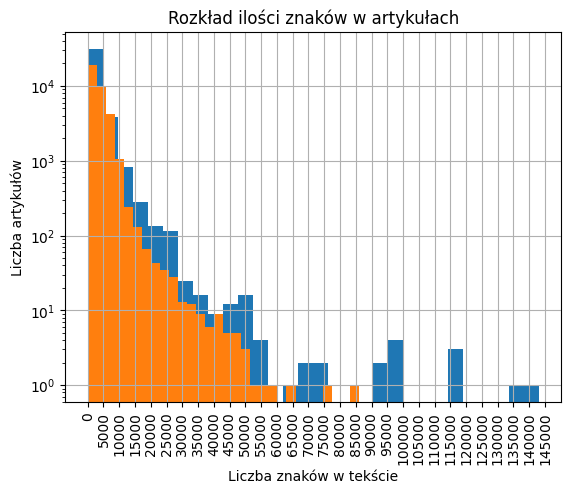

In [15]:
ax = data[data.label == 1].text.str.len().hist(log=True, bins=30)
data[data.label == 0].text.str.len().hist(log=True, bins=30)

ax.set_xlabel('Liczba znaków w tekście')
ax.set_ylabel('Liczba artykułów')
ax.set_title('Rozkład ilości znaków w artykułach')
ax.set_xticks(range(0, 150000, 5000))
plt.xticks(rotation=90)

### Rozkład ilości znaków we wszystkich artykułach pomijając krótsze artykuły od SEQ_LENGTH

(array([     0,   5000,  10000,  15000,  20000,  25000,  30000,  35000,
         40000,  45000,  50000,  55000,  60000,  65000,  70000,  75000,
         80000,  85000,  90000,  95000, 100000, 105000, 110000, 115000,
        120000, 125000, 130000, 135000, 140000, 145000]),
 [Text(0, 0, '0'),
  Text(5000, 0, '5000'),
  Text(10000, 0, '10000'),
  Text(15000, 0, '15000'),
  Text(20000, 0, '20000'),
  Text(25000, 0, '25000'),
  Text(30000, 0, '30000'),
  Text(35000, 0, '35000'),
  Text(40000, 0, '40000'),
  Text(45000, 0, '45000'),
  Text(50000, 0, '50000'),
  Text(55000, 0, '55000'),
  Text(60000, 0, '60000'),
  Text(65000, 0, '65000'),
  Text(70000, 0, '70000'),
  Text(75000, 0, '75000'),
  Text(80000, 0, '80000'),
  Text(85000, 0, '85000'),
  Text(90000, 0, '90000'),
  Text(95000, 0, '95000'),
  Text(100000, 0, '100000'),
  Text(105000, 0, '105000'),
  Text(110000, 0, '110000'),
  Text(115000, 0, '115000'),
  Text(120000, 0, '120000'),
  Text(125000, 0, '125000'),
  Text(130000, 0, '130

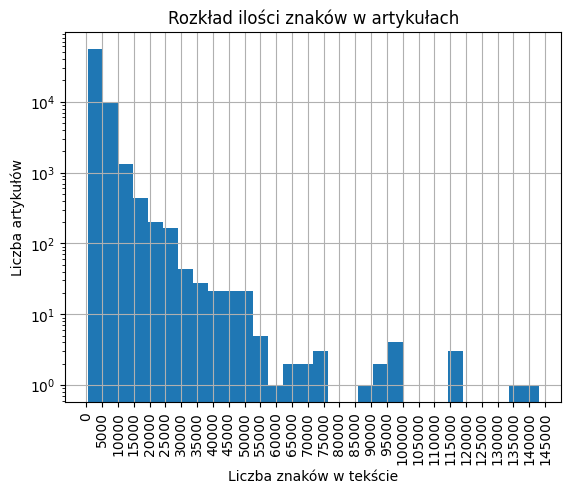

In [16]:
ax = data.text[data.text.str.len() > SEQ_LENGTH].str.len().hist(log=True, bins=30)

ax.set_xlabel('Liczba znaków w tekście')
ax.set_ylabel('Liczba artykułów')
ax.set_title('Rozkład ilości znaków w artykułach')
ax.set_xticks(range(0, 150000, 5000))

plt.xticks(rotation=90)

## Przygotowanie wizualizacji w postaci wordcloud

Taka wizualizacja pozwoli na zobrazowanie które słowa najczęściej występują w danym tekście. Im większe jest dane słowo, tym częściej pojawia się w tekście.

### Funkcja budująca wordcloud

In [17]:
def generate_word_cloud(texts: []):
  use_words = ''

  for text in texts:
    text = str(text)
    tokens = text.split()

    tokens = [_.lower() for _ in tokens]

    use_words += ' '.join(tokens) + ' '

  return WordCloud(width=600, height=600, background_color='white', min_font_size=8).generate(use_words)

### Wizualizacja wordcloud dla tytułów oznaczonych jako fake news

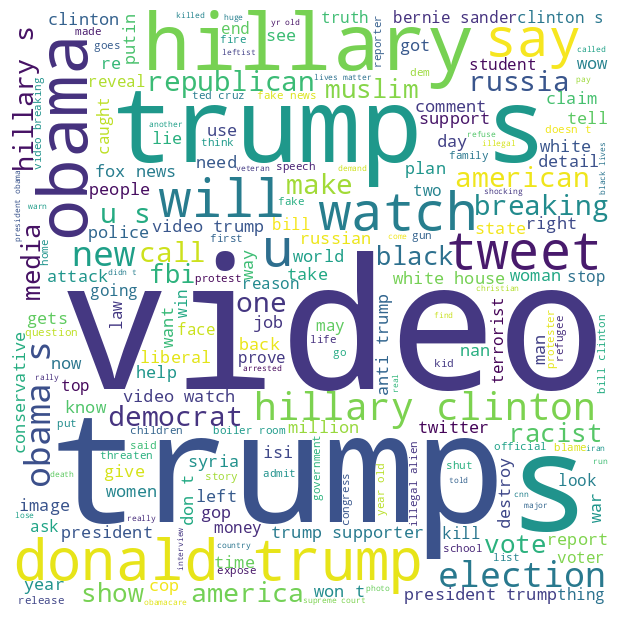

In [18]:
plt.figure(figsize=(6, 6))
plt.imshow(generate_word_cloud(data[data.label == 1].title))
plt.axis('off')
plt.tight_layout(pad=0)

### Wizualizacja wordcloud dla tytułów oznaczonych jako prawdziwe

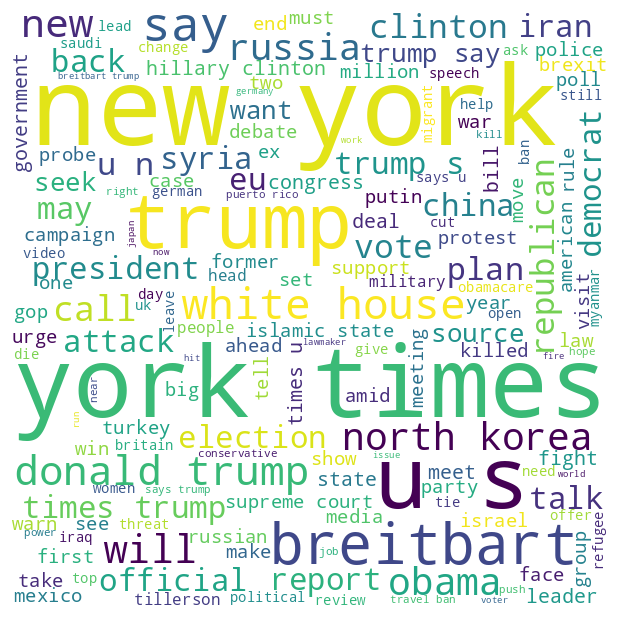

In [19]:
plt.figure(figsize=(6, 6))
plt.imshow(generate_word_cloud(data[data.label == 0].title))
plt.axis('off')
plt.tight_layout(pad=0)

### Wizualizacja wordcloud dla tekstów oznaczonych jako fake news

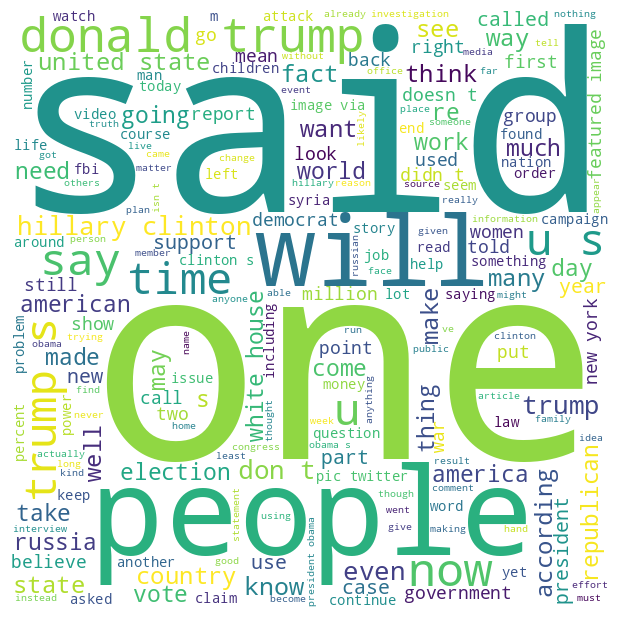

In [20]:
plt.figure(figsize=(6, 6))
plt.imshow(generate_word_cloud(data[data.label == 1].text))
plt.axis('off')
plt.tight_layout(pad=0)

### Wizualizacja wordcloud dla tekstów oznaczonych jako prawdziwe

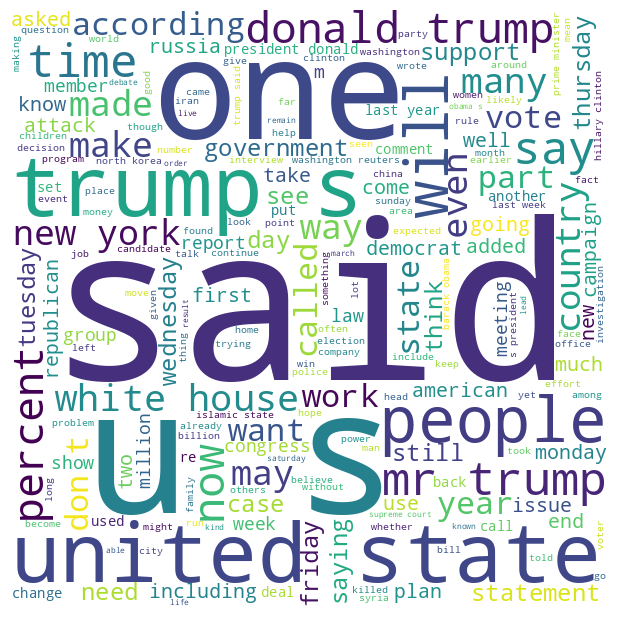

In [21]:
plt.figure(figsize=(6, 6))
plt.imshow(generate_word_cloud(data[data.label == 0].text))
plt.axis('off')
plt.tight_layout(pad=0)

## Obróbka danych

Usunięcie znaków interpunkcyjnych oraz nowej linii.

In [22]:
CHAR_TO_REMOVE_FROM_TEXT = string.punctuation

In [23]:
texts = [
  ''.join([
    c for c in str(t).lower() if c not in CHAR_TO_REMOVE_FROM_TEXT
  ]) for t in data['text']
]

## Zbudowanie mapy słowo na liczbę

Przygotowanie mapy konwertującej każde występujące słowo na unikatową liczbę całkowitą

In [24]:
words = (' '.join(texts)).split()

In [25]:
counts = Counter(words)

vocab_map = {
  word: i for i, word in enumerate(sorted(counts, key=counts.get, reverse=True), 1)
}

vocab_map[''] = 0

## Przekonwertowanie tablicy artykułów

Zamiana tablicy artykułów zapisanych za pomocą słów na tablicę zawierającą ciągi liczb zbudowanych za pomocą mapy

In [26]:
text_ints = []
for t in texts:
  text_ints.append([vocab_map[word] for word in t.split()])

## Zapisanie etykiet w formie wektora

In [27]:
encoded_labels = data.label.to_numpy()

## Pobranie ostatnich znaków z każdej próbki

W ramach treningu model będzie oceniał jedynie ostatnie znaki

In [28]:
def pad_features(text_ints, seq_length=SEQ_LENGTH):
  features = np.zeros((len(text_ints), seq_length))
  for i, row in enumerate(text_ints):
    features[i, -len(row):]= np.array(row)[:seq_length]
  return features

In [29]:
features = pad_features(text_ints, SEQ_LENGTH)

## Podział zbioru danych


Zbiór danych zostanie podzielony na 3 zbiory:
- treningowe — dane do uczenia
- walidacyjne — do oceny modelu podczas treningu
- testowe - do oceny modelu po treningu

Dane zostaną podzielone zgodnie ze zdefiniowanym stosunkiem

In [30]:
train_x = features[:int(len(features)*TRAIN_LEN_SPLIT)]
train_y = encoded_labels[:int(len(encoded_labels)*TRAIN_LEN_SPLIT)]

val_x = features[
  int(len(features)*TRAIN_LEN_SPLIT):int(len(features)*TRAIN_LEN_SPLIT + len(features)*VAL_LEN_SPLIT)
]
val_y = encoded_labels[
  int(len(encoded_labels)*TRAIN_LEN_SPLIT):int(len(encoded_labels)*TRAIN_LEN_SPLIT + len(encoded_labels)*VAL_LEN_SPLIT)
]

test_x = features[
  int(len(features)*TRAIN_LEN_SPLIT + len(features)*VAL_LEN_SPLIT)
  :
  int(len(features)*TRAIN_LEN_SPLIT + len(features)*VAL_LEN_SPLIT + len(features)*TEST_LEN_SPLIT)
]
test_y = encoded_labels[
  int(len(encoded_labels)*TRAIN_LEN_SPLIT + len(encoded_labels)*VAL_LEN_SPLIT)
  :
  int(len(encoded_labels)*TRAIN_LEN_SPLIT + len(encoded_labels)*VAL_LEN_SPLIT + len(encoded_labels)*TEST_LEN_SPLIT)
]

### Sprawdzenie rozmiaru poszczególnych zbiorów

#### Zbiór treningowy

In [31]:
train_x.shape

(49945, 400)

#### Zbiór walidacyjny

In [32]:
val_x.shape

(7135, 400)

#### Zbiór testowy

In [33]:
test_x.shape

(14271, 400)

# Trening modelu o własnej architekturze

## Zdefiniowanie ustawień modelu

In [34]:
PATIENCE = 15
DELTA = 0

BATCH_SIZE = 16
EPOCHS = 100
EMBEDDING_DIM = 256
N_HIDDEN = 256
N_LAYERS = 2
CLIP_GRAD = 15
DROPOUT = 0.4

MODEL_CUSTOM_PATH = os.path.join(os.path.join(MODEL_PATH, 'model.pt'))

## Utworzenie klas pomocniczych

### Klasa EarlyStoping

Klasa pozwalająca zatrzymać trenowanie modelu, jeżeli model nie będzie uczył się dla zbioru walidacyjne.

In [35]:
class EarlyStoping:
  def __init__(self, patience, delta = 0, operator = np.less, model_path = None):
    self.PATIENCE = patience
    self.DELTA = delta
    self.operator = operator
    self.model_path = model_path

    self.trigger = 0
    self.best_score = None

  def continue_training(self, actual_value, model):
    if self.best_score is not None and self.operator(self.best_score + self.DELTA, actual_value):
      self.trigger += 1

      if self.trigger >= self.PATIENCE:
        return False
    else:
      self.trigger = 0
      self.best_score = actual_value
      if self.model_path is not None and model is not None:
        torch.save(model.state_dict(), self.model_path)
    return True

### Funkcja tworząca logger TensorBoard

In [36]:
def get_tensorboard_writer():
  path = os.path.join(LOGS_PATH, f'{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}')
  writer = tensorboard.SummaryWriter(path)

  for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
      os.unlink(file_path)

  return writer

## Przygotowanie danych do treningu modelu w PyTorch

### Utworzenie tensorów dla wczytanych zbiorów

In [37]:
train_data = torch.utils.data.TensorDataset(
  torch.from_numpy(train_x), torch.from_numpy(train_y)
)

val_data = torch.utils.data.TensorDataset(
  torch.from_numpy(val_x), torch.from_numpy(val_y)
)

test_data = torch.utils.data.TensorDataset(
  torch.from_numpy(test_x), torch.from_numpy(test_y)
)

### Stworzenie DataLoader

In [38]:
train_loader = torch.utils.data.DataLoader(
  train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
  val_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
  test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True, num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Definicja modelu

In [39]:
class Net(torch.nn.Module):
  def __init__(self, input_size, embedding_dim, hidden_size, n_layers, output_size, drop=0):
    super(Net, self).__init__()
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size
    self.n_layers = n_layers
    self.output_size = output_size

    self.embedding = torch.nn.Embedding(input_size, self.embedding_dim, padding_idx=0)
    self.lstm = torch.nn.LSTM(
      self.embedding_dim, self.hidden_size, self.n_layers, batch_first=True
    )
    self.drop = torch.nn.Dropout(drop)
    self.fc = torch.nn.Linear(self.hidden_size, self.output_size)
    self.sig = torch.nn.Sigmoid()


  def forward(self, x):
    batch_size = x.size(0)

    h = torch.zeros((self.n_layers, batch_size, self.hidden_size)).to(DEVICE)
    c = torch.zeros((self.n_layers, batch_size, self.hidden_size)).to(DEVICE)

    torch.nn.init.xavier_normal_(h)
    torch.nn.init.xavier_normal_(c)

    out = self.embedding(x.long())
    out, (h, c) = self.lstm(out, (h, c))
    out = self.drop(out)
    out = self.fc(out)
    out = self.sig(out)

    return out.view(batch_size, -1)[:, -1]

## Utworzenie modelu

In [40]:
model = Net(len(vocab_map), EMBEDDING_DIM, N_HIDDEN, N_LAYERS, 1, DROPOUT)

### Przeniesienie modelu na urządzenie do treningu

In [41]:
model.to(DEVICE)

Net(
  (embedding): Embedding(445974, 256, padding_idx=0)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (drop): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

### Wyświetlenie modelu

In [42]:
summary(
  model,
  next(iter(train_loader))[0].to(DEVICE),
)

              Kernel Shape    Output Shape       Params    Mult-Adds
Layer                                                               
0_embedding  [256, 445974]  [16, 400, 256]  114.169344M  114.169344M
1_lstm                   -  [16, 400, 256]    1.052672M    1.048576M
2_drop                   -  [16, 400, 256]            -            -
3_fc              [256, 1]    [16, 400, 1]        257.0        256.0
4_sig                    -    [16, 400, 1]            -            -
--------------------------------------------------------------------
                           Totals
Total params          115.222273M
Trainable params      115.222273M
Non-trainable params          0.0
Mult-Adds             115.218176M


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_embedding,"[256, 445974]","[16, 400, 256]",114169344.0,114169344.0
1_lstm,-,"[16, 400, 256]",1052672.0,1048576.0
2_drop,-,"[16, 400, 256]",NaN,NaN
3_fc,"[256, 1]","[16, 400, 1]",257.0,256.0
4_sig,-,"[16, 400, 1]",NaN,NaN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


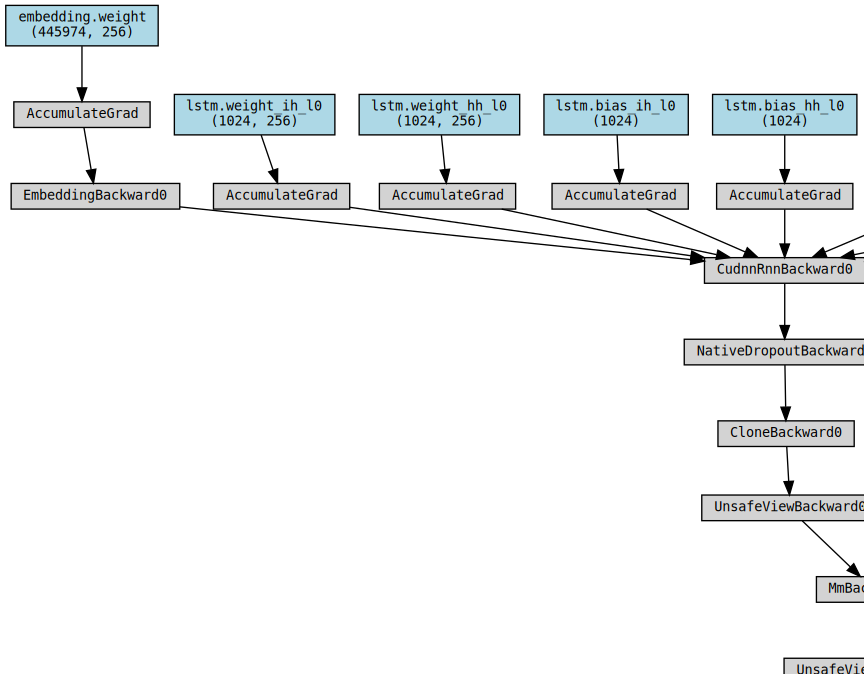

In [43]:
y = model(next(iter(train_loader))[0].to(DEVICE))

make_dot(y.mean(), params=dict(model.named_parameters()))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


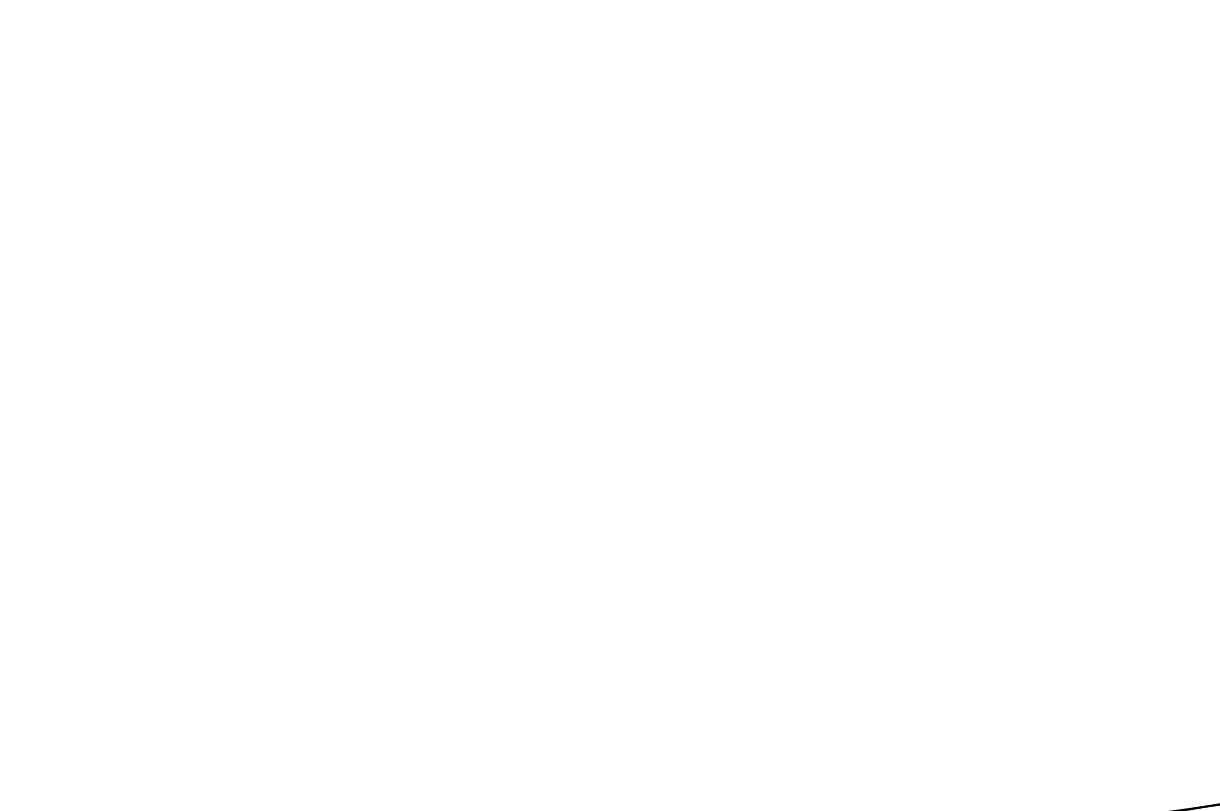

In [44]:
y = model(next(iter(train_loader))[0].to(DEVICE))

make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

### Wczytanie wytrenowanego modelu

In [45]:
if os.path.exists(MODEL_CUSTOM_PATH):
  model.load_state_dict(torch.load(MODEL_CUSTOM_PATH))

### Kompilacja modelu

W najnowszych wersjach treningu kompilacja przyśpiesza trening modelu, ale jest dostępna tylko na CUDA.

In [46]:
czas_kompilacji = None
if DEVICE.type == 'cuda' and NIGHTLY:
  start_kompilacji = datetime.now()
  model = torch.compile(model, mode='reduce-overhead')
  czas_kompilacji = datetime.now() - start_kompilacji

print(f'Na kompilacje modelu potrzebne było {czas_kompilacji}')

Na kompilacje modelu potrzebne było None


## Przebieg treningu

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=1, verbose=True)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=None)
criterion = torch.nn.BCELoss()
early_stopping = EarlyStoping(PATIENCE, delta=DELTA, operator=np.greater_equal, model_path=MODEL_CUSTOM_PATH)

writer = get_tensorboard_writer()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_treningu = datetime.now()
for epoch in range(EPOCHS):
  with tqdm(train_loader, unit=' batch') as tepoch:
    tepoch.set_description(f'Epoch {epoch+1}/{EPOCHS}')

    train_loss = 0
    correct = 0
    losses = []

    model.train()

    for batch_idx, (source, target) in enumerate(tepoch):
      source, target = source.to(DEVICE), target.to(DEVICE)

      optimizer.zero_grad()

      output = model(source)
      loss = criterion(output, target.float())
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
      optimizer.step()

      losses.append(loss.item())
      predictions = torch.where(output > 0.5, 1.0, 0.0)
      correct += predictions.eq(target.view_as(predictions)).sum().detach()

      # scheduler.step(np.mean(losses))

      tepoch.set_postfix({
        'loss': round(np.mean(losses), 3),
        'acc': round((correct / ((batch_idx + 1) * BATCH_SIZE)).item(), 3)
      })

    train_loss = np.mean(losses)
    acc = (correct / float(len(train_loader.dataset))).item()

    train_losses.append(train_loss)
    train_accuracies.append(acc)

    model.eval()
    correct = 0
    val_loss = []

    with torch.no_grad():
      for source, target in val_loader:
        source, target = source.to(DEVICE), target.to(DEVICE)

        output = model(source)

        val_loss.append(criterion(output, target.float()).item())

        predictions = torch.where(output > 0.5, 1.0, 0.0)
        correct += predictions.eq(target.view_as(predictions)).sum().detach()
    val_acc = (correct / float(len(val_loader.dataset)))
    val_accuracies.append(val_acc)

    val_losses.append(np.mean(val_loss))

    scheduler.step(val_acc)

    writer.add_scalars('accuracy', {
      'train': acc,
      'validation': val_acc
    }, epoch)

    writer.add_scalars('loss', {
      'train': train_loss,
      'validation': np.mean(val_loss)
    }, epoch)

    if not early_stopping.continue_training(val_acc.item(), model):
      tepoch.write(
        f'Early stoping Epoch: {epoch+1} \
Train loss {train_loss:.5f} Train accuracy {acc:.5f} \
Val loss: {np.mean(val_loss):.5f} Val accuracy: {val_acc:.5f}'
      )
      break

#   tepoch.write(
#     f'Train loss {train_loss:.5f} Train accuracy {acc:.5f} \
# Val loss: {np.mean(val_loss):.5f} Val accuracy: {val_acc:.5f}'
#   )
writer.close()
print(f'Model wytrenował się w {datetime.now() - start_treningu}')

Epoch 1/100:   0%|          | 0/3121 [00:00<?, ? batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5/100: 100%|██████████| 3121/3121 [02:54<00:00, 17.93 batch/s, loss=0.127, acc=0.955]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


Epoch 7/100: 100%|██████████| 3121/3121 [02:48<00:00, 18.50 batch/s, loss=0.074, acc=0.974]


Epoch 00007: reducing learning rate of group 0 to 1.0000e-06.


Epoch 9/100: 100%|██████████| 3121/3121 [02:48<00:00, 18.55 batch/s, loss=0.067, acc=0.977]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-07.


Epoch 11/100: 100%|██████████| 3121/3121 [02:47<00:00, 18.64 batch/s, loss=0.066, acc=0.977]


Epoch 00011: reducing learning rate of group 0 to 1.0000e-08.


Epoch 27/100: 100%|██████████| 3121/3121 [02:49<00:00, 18.45 batch/s, loss=0.066, acc=0.977]


Early stoping Epoch: 27 Train loss 0.06595 Train accuracy 0.97709 Val loss: 0.09530 Val accuracy: 0.96468
Model wytrenował się w 1:18:47.098869


# Test modelu o własnej architekturze

## Funkcja testująca model

In [48]:
def test_model(model, criterion, loader):
  correct = 0
  test_loss = []

  y_predictions = []
  y_test = []

  model.eval()

  with torch.no_grad():
    for batch_idx, (source, target) in enumerate(tqdm(loader)):
      source, target = source.to(DEVICE), target.to(DEVICE)

      output = model(source)

      test_loss.append(criterion(output, target.float()).item())

      predictions = torch.where(output > 0.5, 1.0, 0.0)
      y_predictions.extend(predictions)
      y_test.extend(target)

      correct += predictions.eq(target.view_as(predictions)).sum().detach()
    test_acc = (correct / float(len(test_loader.dataset)))
  return test_loss, test_acc, torch.stack(y_predictions).cpu(), torch.stack(y_test).cpu()

## Sprawdzenie ostatniej wersji modelu na zestawie testowym

In [49]:
test_loss, test_acc, _, _ = test_model(model, torch.nn.BCELoss(), test_loader)
print(f'Test loss {np.mean(test_loss):.5f} Test acc: {(test_acc*100):.5f}%')

100%|██████████| 891/891 [00:12<00:00, 70.85it/s]

Test loss 0.10018 Test acc: 96.57346%


## Wczytanie najlepszej wersji modelu

Zostanie załadowana wersja modelu, która uzyskała najniższą wartość funkcji straty

In [50]:
model.load_state_dict(torch.load(MODEL_CUSTOM_PATH))

<All keys matched successfully>

## Sprawdzenie modelu na zestawie testowym

Zostanie sprawdzany zupełnie nowy zestaw danych. Model nigdy wcześniej nie widział danych z tego zestawu

In [51]:
test_loss, test_acc, y_predictions, y_test = test_model(model, torch.nn.BCELoss(), test_loader)

print(f'Test loss {np.mean(test_loss):.5f} Test acc: {(test_acc*100):.5f}%')

100%|██████████| 891/891 [00:14<00:00, 61.36it/s]

Test loss 0.10002 Test acc: 96.58047%


## Wyświetlanie macierzy pomyłek

<Axes: >

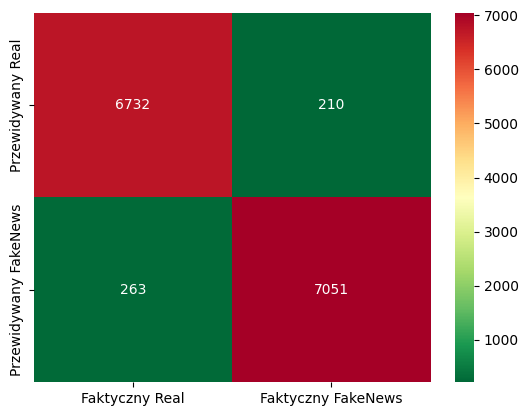

In [52]:
cf = confusion_matrix(y_predictions, y_test)
df_cm = pd.DataFrame(
  cf,
  index=[i for i in ['Przewidywany Real', 'Przewidywany FakeNews']],
  columns=[i for i in ['Faktyczny Real', 'Faktyczny FakeNews']]
)

sns.heatmap(df_cm, annot=True, cmap='RdYlGn_r', fmt='d')

In [53]:
np.count_nonzero(test_y == 1)

7267

In [54]:
np.count_nonzero(test_y == 0)

7004

In [55]:
cf.sum(axis=0)

array([6995, 7261])

In [56]:
cf

array([[6732,  210],
       [ 263, 7051]])

## Zapisanie grafu utworzonego modelu

In [57]:
writer_model = tensorboard.SummaryWriter(GRAPH_PATH)
writer_model.add_graph(model, next(iter(train_loader))[0].to(DEVICE))
writer_model.close()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:1084: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%hx.1 : Float(2, 16, 256, strides=[4096, 256, 1], requires_grad=0, device=cuda:0) = aten::normal_(%tensor.1, %88, %89, %90) # /usr/local/lib/python3.10/dist-packages/torch/nn/init.py:19:0
	%hx : Float(2, 16, 256, strides=[4096, 256, 1], requires_grad=0, device=cuda:0) = aten::normal_(%tensor, %113, %114, %115) # /usr/local/lib/python3.10/dist-packages/torch

## Zapisanie projektora najlepszego modelu

Zapisanie modelu w postaci powiązań w celu wizualizacji danych

In [58]:
writer_projector = tensorboard.SummaryWriter(PROJECTOR_PATH)
writer_projector.add_embedding(model.embedding.weight, metadata=vocab_map.keys())
writer_projector.close()

## Sprawdzenie modelu na 1 próbce

### Wybranie próbki do sprawdzenia

In [59]:
random_probe = randrange(len(text_ints))

### Wyświetlenie wybranego artykułu

In [60]:
data.loc[data.index[random_probe]]

ID                                                      69416
title       Evan McMullin, Anti-Trump Republican, Mounts I...
text        Evan McMullin, a former C. I. A. official and ...
label                                                       0
category                                                 real
Name: 69416, dtype: object

#### Funkcja konwertująca liczby na odpowiadające im znaki

In [61]:
def convert_array_ints_to_string(text: [], vocab_map: dict):
  words = list(vocab_map.keys())

  return [words[_ - 1] for _ in text]

#### Wyświetlenie wybranego tekstu do sprawdzenia

In [62]:
' '.join(convert_array_ints_to_string(text_ints[random_probe], vocab_map))

'evan mcmullin a former c i a official and a republican who passionately opposes donald j trump announced monday that he would run for president as an independent candidate mr mcmullin who until recently worked on policy development with the house republican conference has missed the deadlines in more than two dozen states but mr mcmullin a member of the church of jesus christ of saints studied in utah and could take votes from mr trump in the heavily mormon state in an interview mr mcmullin said he was strongly opposed to both mr trump and hillary clinton the democratic nominee but his harshest words and his clearest motivation appeared to come from mr trump’s candidacy “really what’s impacted me is the way trump’s treated our veterans our heroes” he said “the things he said about john mccain the things he said about the khan family and mrs khan ” mr trump last year disparaged mr mccain’s status as a war hero because the republican senator from arizona was captured and more recently h

### Sprawdzenie modelu

#### Przesłanie wybranego tekstu do modelu

In [63]:
output = model(
  torch.from_numpy(pad_features(text_ints[random_probe:random_probe+1])).to(DEVICE)
)

#### Porównanie odpowiedzi modelu z wartością oczekiwana

In [64]:
ans_model = torch.round(output)
print(
  f'Według modelu ten artyk;u jest {"prawdziwy" if ans_model == 0 else "fałszywy"} \
i jest tego pewny na {((output if ans_model == 1 else 1 - output).item()*100):.2f}%.'
)

Według modelu ten artyk;u jest prawdziwy i jest tego pewny na 99.63%.


In [65]:
print(f'Prawidłowa odpowiedź to: artykuł to {"prawda" if encoded_labels[random_probe] == 0 else "fałsz"}.')

Prawidłowa odpowiedź to: artykuł to prawda.


In [66]:
print(
  f'Odpowiedź modelu {"nie " if ans_model != encoded_labels[random_probe] else ""}zgadza sie z wartością oczekiwana.'
)

Odpowiedź modelu zgadza sie z wartością oczekiwana.
